In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
from collections import Counter
from scipy.stats import mode
import pandas as pd
FIG_DIR='/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/'
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
from scipy.cluster.hierarchy import fcluster


# Getting fastas for phylogenetic tree creation (clustalW on EMBL)

In [142]:
for name in ['hhv_6a_start', 'hhv_6a_end', 'hhv_6b_start', 'hhv_6b_end']:
    print(name)
    records = [r for r in SeqIO.parse('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/%s_aligned.fa' % name, format='fasta')]
    df = pd.DataFrame([list(r.seq) for r in records])#.replace('A', 1).replace('-', 0).replace('T', 2).replace('G', 3).replace('C', 4).replace('a', 1).replace('t', 2).replace('g', 3).replace('c', 4)
    df.index = [r.id for r in records]
    df.index = [i.replace('_LCL', '-LCL').split('_')[-6].replace('-LCL', '_LCL') for i in df.index]
    #df = df.apply(pd.to_numeric)
    consensus = df.apply(lambda x: mode(x)[0], axis=0).values[0]
    df = df.iloc[np.argsort(((df!=consensus)).sum(axis=1)).values]
    _, is_unique = np.unique(df.index, return_index=True)
    df = df.iloc[is_unique]
    df = df[df.columns[df.sum(axis=0)!=0]]
    df.index = ['%s/%s' % (i,j) for i,j in zip(bam_mappings.loc[df.index].family.values, df.index)]
    with open('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_for_tree.fa' % name, 'w') as f:
        for k,v in zip(df.apply(''.join, axis=1).keys(), df.apply(''.join, axis=1).values):
            f.write('>' + k + '\n')
            f.write(v + '\n')

            
 

In [2]:
for name in ['hhv_6A', 'hhv_6B', 'hhv_7']:
    print(name)
    records = [r for r in SeqIO.parse('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/%s_aligned.fa' % name, format='fasta')]
    df = pd.DataFrame([list(r.seq) for r in records])#.replace('A', 1).replace('-', 0).replace('T', 2).replace('G', 3).replace('C', 4).replace('a', 1).replace('t', 2).replace('g', 3).replace('c', 4)
    df.index = [r.id for r in records]
    df.index = [i.split('.')[0] for i in df.index]
    #df = df.apply(pd.to_numeric)
    consensus = df.apply(lambda x: mode(x)[0], axis=0).values[0]
    df = df.iloc[np.argsort(((df!=consensus)).sum(axis=1)).values]
    _, is_unique = np.unique(df.index, return_index=True)
    df = df.iloc[is_unique]
    df = df[df.columns[df.sum(axis=0)!=0]]
    df.index = ['%s/%s' % (i,j) for i,j in zip(bam_mappings.loc[df.index].family.values, df.index)]
    with open('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_for_tree.fa' % name, 'w') as f:
        for k,v in zip(df.apply(''.join, axis=1).keys(), df.apply(''.join, axis=1).values):
            f.write('>' + k + '\n')
            f.write(v + '\n')

hhv_6A
hhv_6B
hhv_7


In [4]:
from scipy.stats import mannwhitneyu

for name in ['hhv_6a_start', 'hhv_6a_end', 'hhv_6b_start', 'hhv_6b_end', 'hhv_6A', 'hhv_6B', 'hhv_7']:
    print(name)
    all_dists = []
    dists = []
    index = []
    with open('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_dist_mat.txt' % name) as f:
        for i,l in enumerate(f.readlines()):
            if i==0: continue
            l = l.replace('\n', '')
            elements = l.split(' ')
            if elements[0][:2]=='AU':
                index = index + [elements[0]]
                elements = elements[1:]
                all_dists = all_dists + [dists]
                dists = []
            dists = dists + [float(e) for e in elements if e!='']
    all_dists = all_dists[1:] + [dists]
    print(len(all_dists))
    dist_mat = pd.DataFrame(all_dists)
    dist_mat.columns = index
    dist_mat.index = index
    is_same_fam = pd.DataFrame([[1 if ((i==j) and (i_idx<j_idx)) else np.nan for i_idx, i in enumerate([ii.split('/')[0] for ii in index])] for j_idx,j in enumerate([ii.split('/')[0] for ii in index])])
    is_diff_fam = pd.DataFrame([[1 if ((i!=j) and (i_idx<j_idx)) else np.nan for i_idx, i in enumerate([ii.split('/')[0] for ii in index])] for j_idx,j in enumerate([ii.split('/')[0] for ii in index])])
    dists_same_fam = (dist_mat.values*is_same_fam.values).flatten()
    dists_same_fam = dists_same_fam[~np.isnan(dists_same_fam)]
    dists_diff_fam = (dist_mat.values*is_diff_fam.values).flatten()
    dists_diff_fam = dists_diff_fam[~np.isnan(dists_diff_fam)]

    print(mannwhitneyu(dists_same_fam, dists_diff_fam))

hhv_6a_start
14
MannwhitneyuResult(statistic=183.5, pvalue=0.0005657357905044444)
hhv_6a_end
14
MannwhitneyuResult(statistic=192.5, pvalue=0.0002579754411994861)
hhv_6b_start
54
MannwhitneyuResult(statistic=6623.0, pvalue=0.18668633450902905)
hhv_6b_end
52
MannwhitneyuResult(statistic=3063.0, pvalue=0.0013112983381271884)
hhv_6A
15
MannwhitneyuResult(statistic=110.5, pvalue=4.406548907387145e-07)
hhv_6B
77
MannwhitneyuResult(statistic=10155.5, pvalue=8.145113792522984e-12)
hhv_7
107
MannwhitneyuResult(statistic=10659.5, pvalue=0.003097076129431013)


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


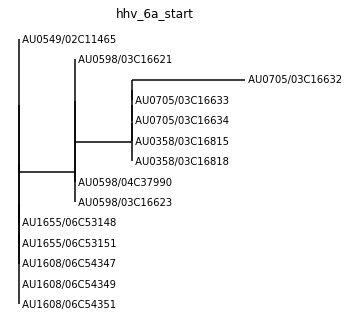

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later


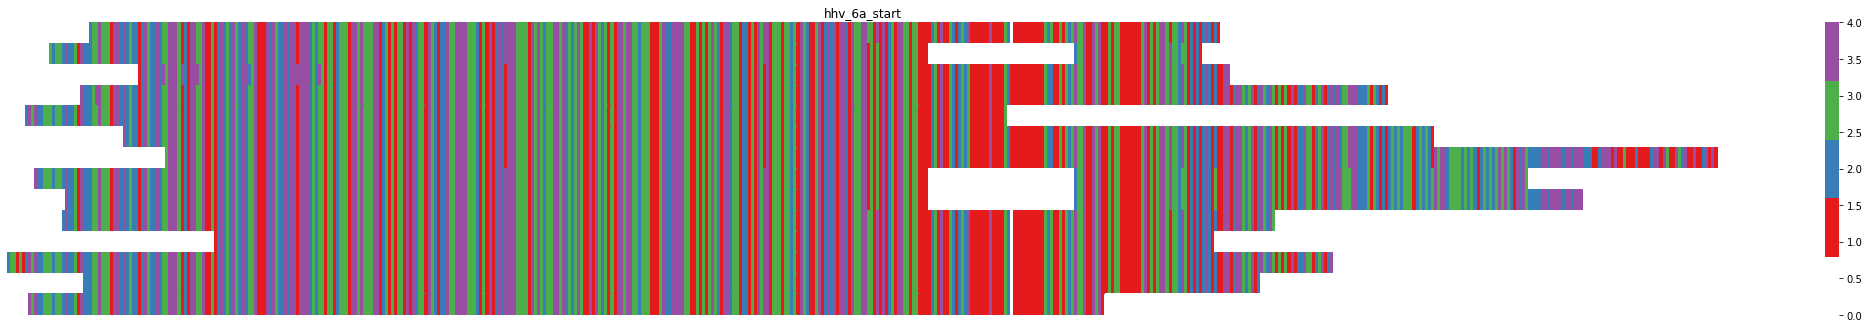

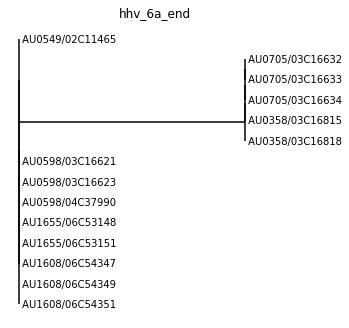

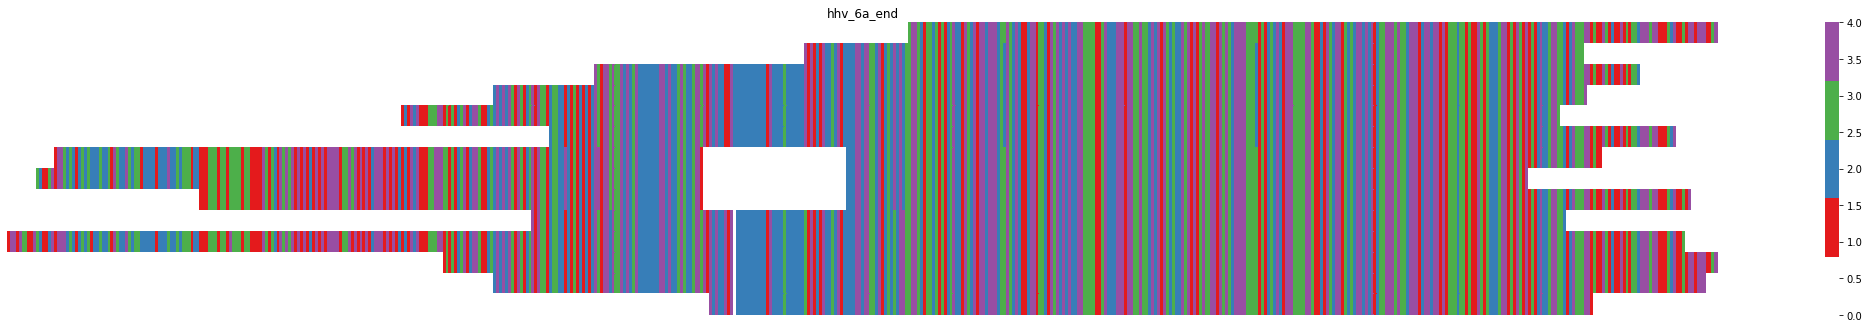

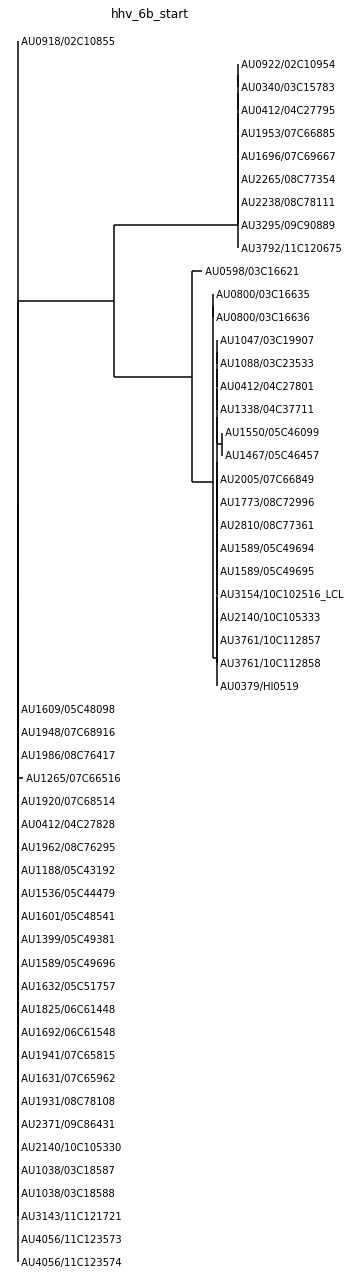

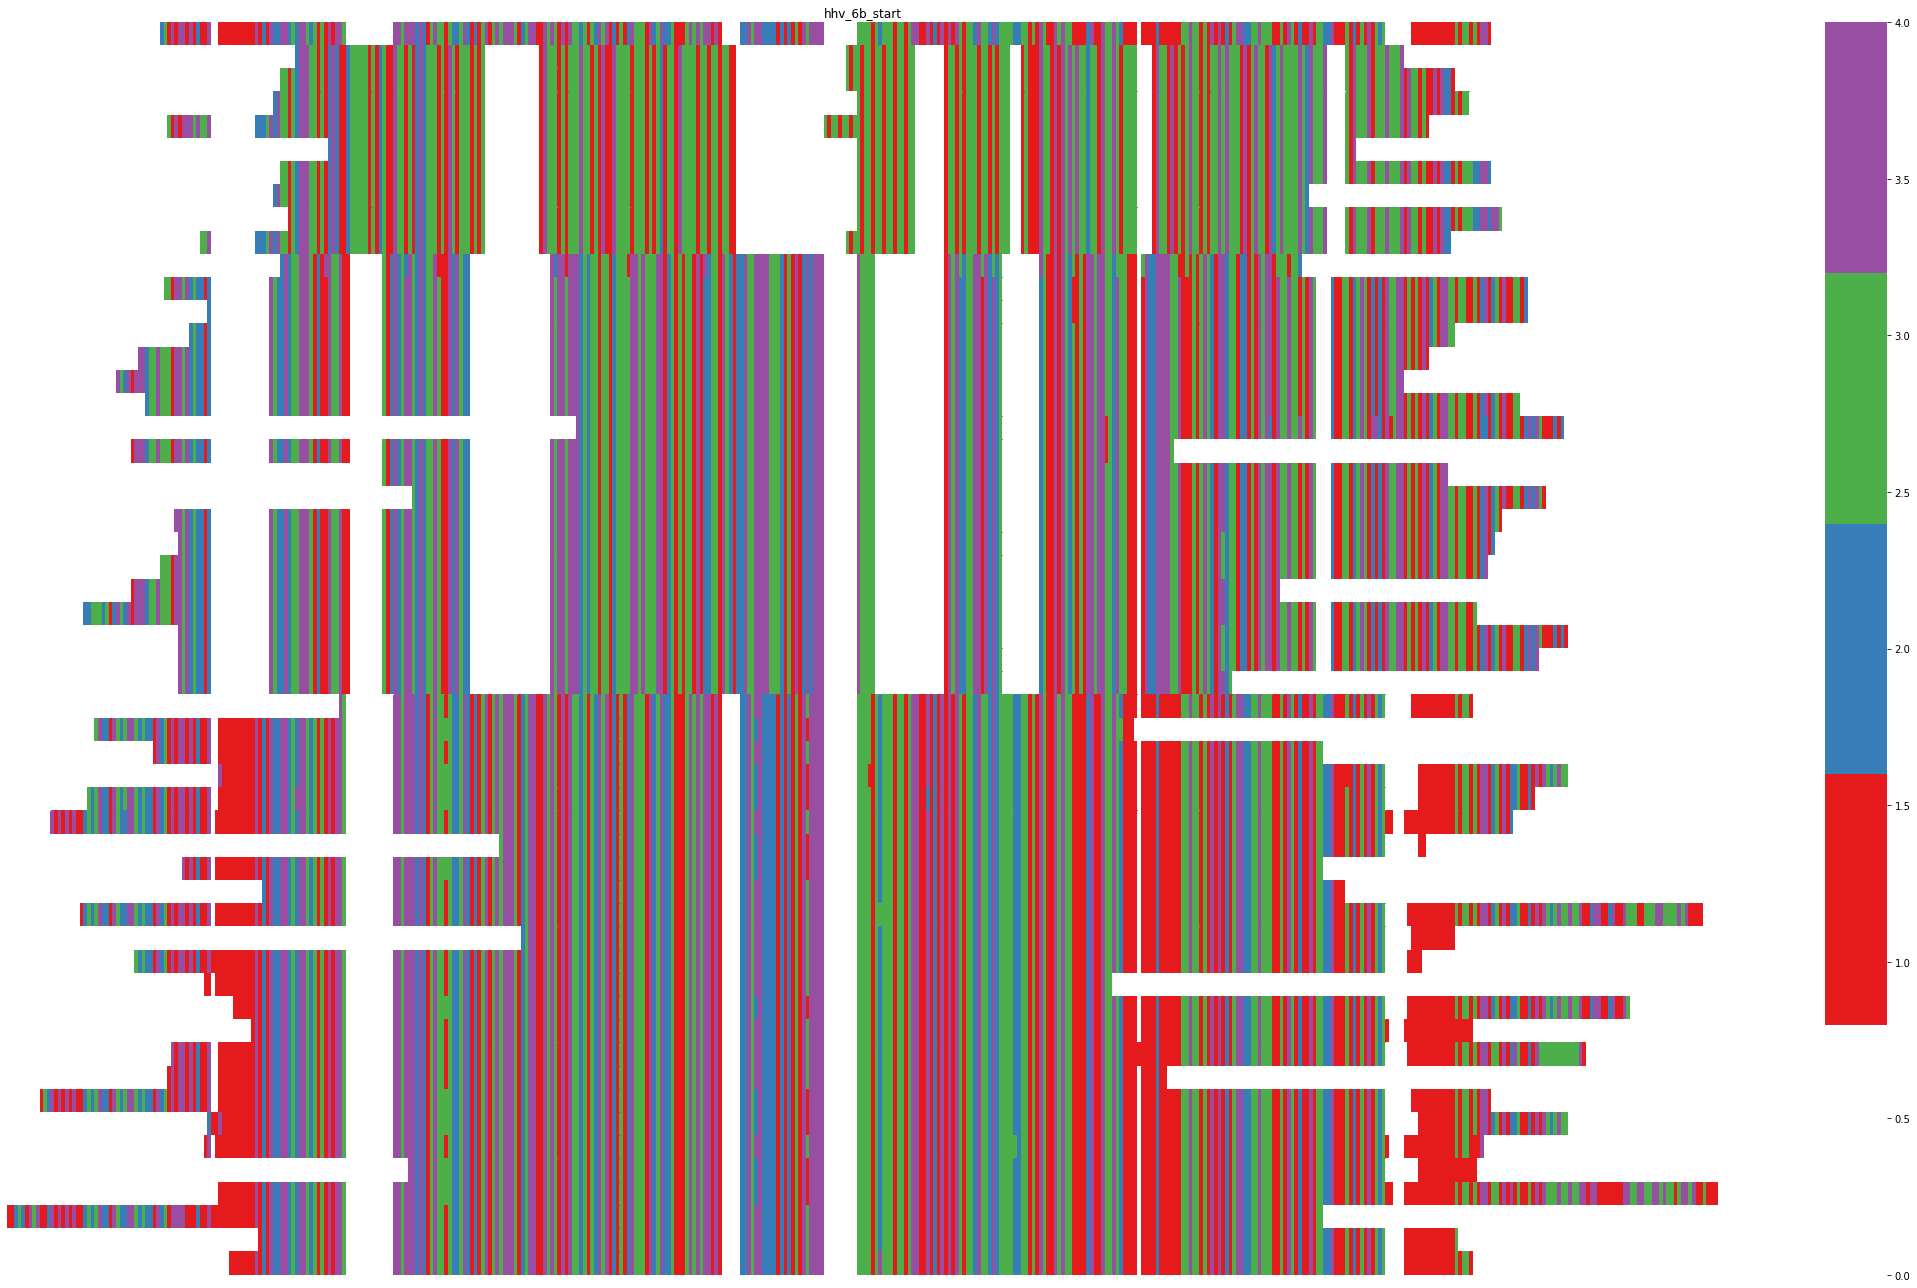

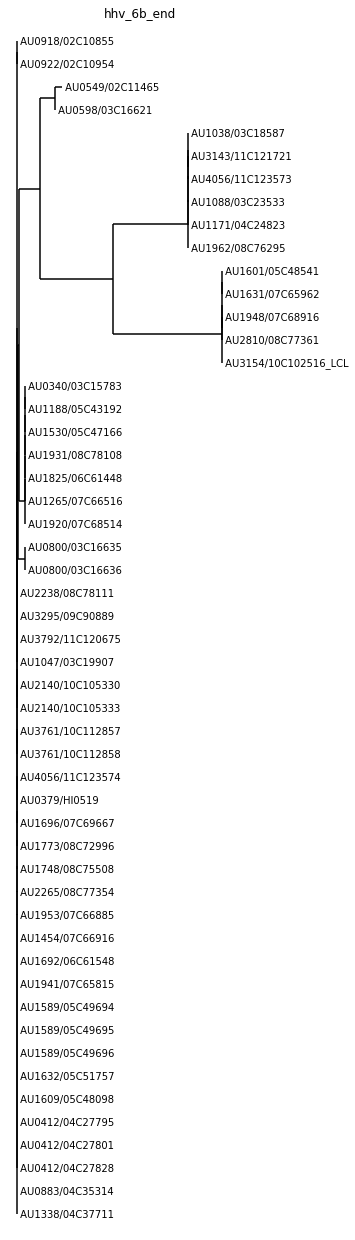

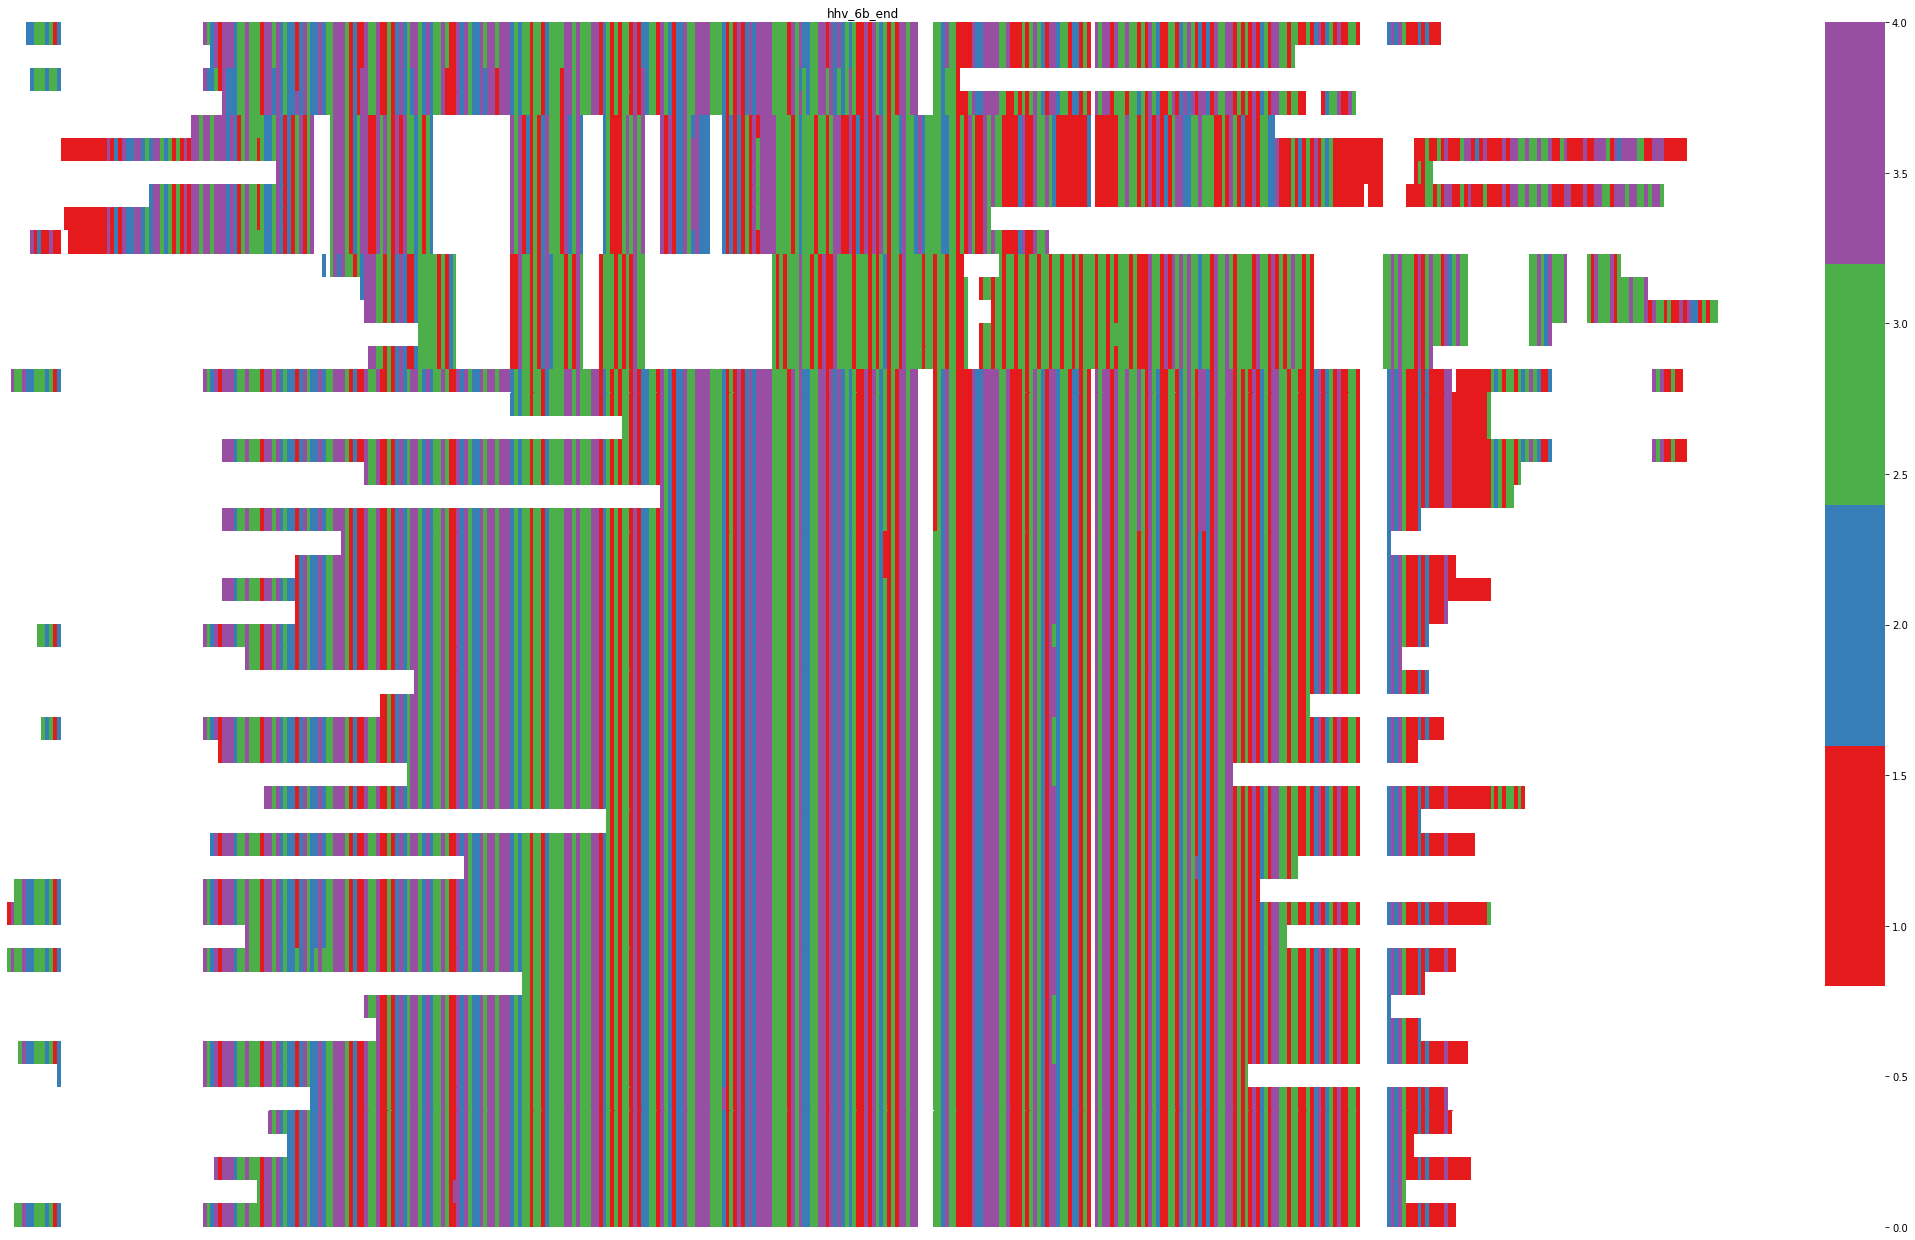

In [15]:
from Bio import Phylo


for name in ['hhv_6a_start', 'hhv_6a_end', 'hhv_6b_start', 'hhv_6b_end']:
    
    # Loading and setting up files & index order.
    records = [r for r in SeqIO.parse('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_for_tree.fa' % name, format='fasta')]
    tree_file = '/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_tree.ph'% name
    tree = [t for t in Phylo.parse(tree_file, "newick")][0]
    f, ax = plt.subplots(figsize=(5,len(records)/3))
    ax.set_title(name)
    ax.axis('off')
    Phylo.draw(tree, axes=ax, do_show=False)
    plt.tight_layout()
    plt.savefig(FIG_DIR + 'diversity_tree_%s.svg' % name, tight_layout=True)
    plt.show()
    index_order = [o.name for o in tree.find_elements(order='preorder', terminal=True)]

    df = pd.DataFrame([list(r.seq) for r in records]).replace('A', 1).replace('-', 0).replace('T', 2).replace('N', 5).replace('n', 5).replace('G', 3).replace('C', 4).replace('a', 1).replace('t', 2).replace('g', 3).replace('c', 4)
    df.index = [r.id for r in records]
    df = df.loc[index_order]
    df = df[df.columns[df.sum(axis=0)!=0]]
    # Make plot.
    plt.figure(figsize=(30,len(df)/3))
    cp = sns.color_palette([(1, 1, 1)] + list(sns.color_palette('Set1', 4))) #+ [(.3,.3,.3), (.3,.3,.3)]) 
    c = sns.heatmap(df, cmap = cp)
    plt.title(name)
    c.set_xticks([])
    c.set_yticks([])
    plt.tight_layout()
    plt.savefig(FIG_DIR + 'diversity_%s.svg' % name, tight_layout=True)
    plt.show()



/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


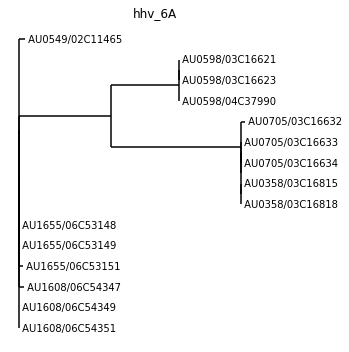

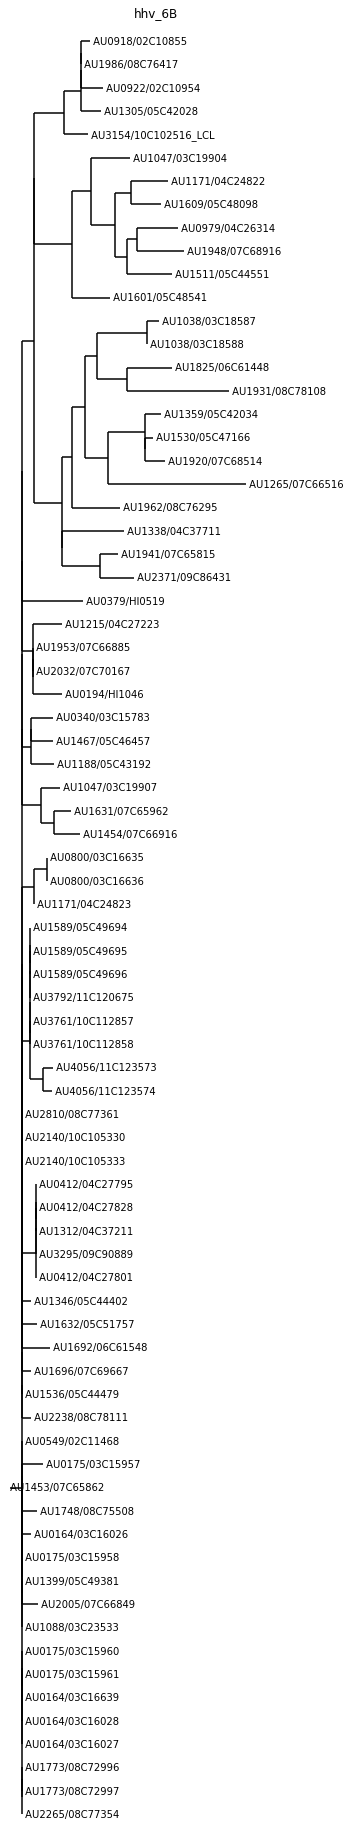

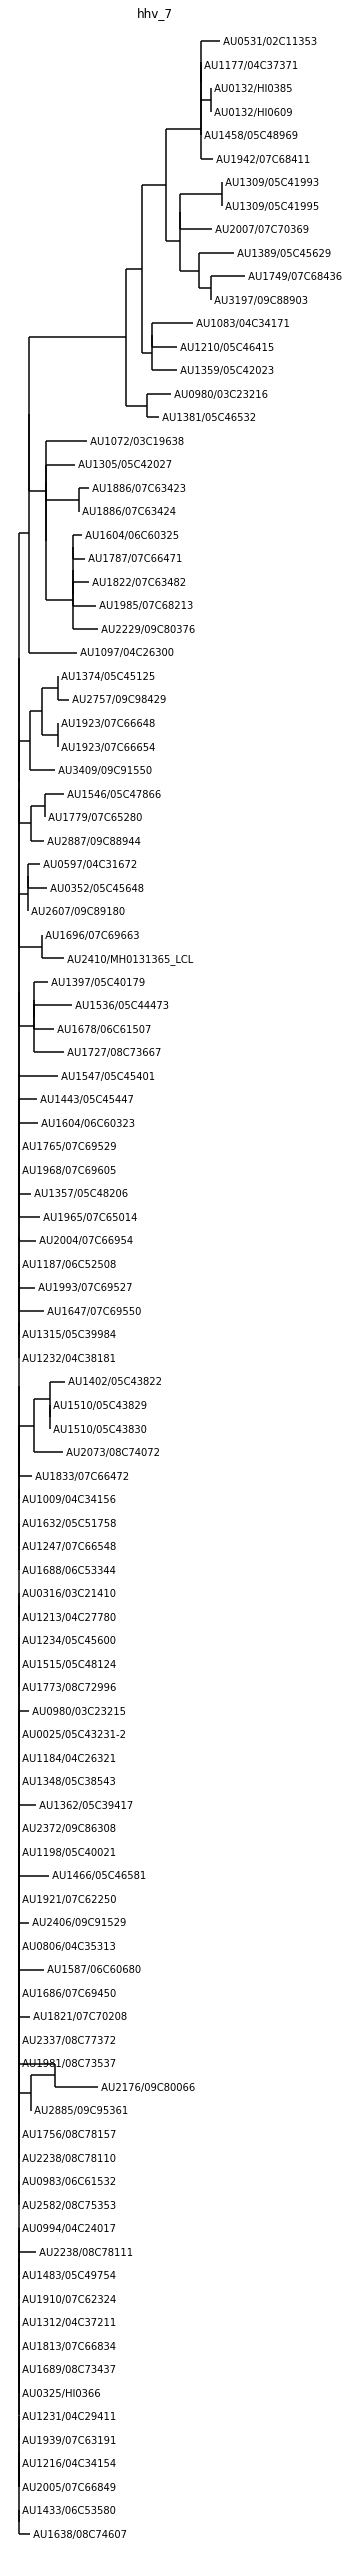

In [3]:
from Bio import Phylo


for name in ['hhv_6A', 'hhv_6B', 'hhv_7']:
    
    # Loading and setting up files & index order.
    records = [r for r in SeqIO.parse('/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_for_tree.fa' % name, format='fasta')]
    tree_file = '/home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus_tree/%s_tree.ph'% name
    tree = [t for t in Phylo.parse(tree_file, "newick")][0]
    f, ax = plt.subplots(figsize=(5,len(records)/3))
    ax.set_title(name)
    ax.axis('off')
    Phylo.draw(tree, axes=ax, do_show=False)
    plt.tight_layout()
    plt.savefig(FIG_DIR + 'diversity_tree_%s.svg' % name, tight_layout=True)
    plt.show()
    index_order = [o.name for o in tree.find_elements(order='preorder', terminal=True)]

    #df = pd.DataFrame([list(r.seq) for r in records]).replace('x', 5).replace('A', 1).replace('-', 0).replace('T', 2).replace('N', 5).replace('n', 5).replace('G', 3).replace('C', 4).replace('a', 1).replace('t', 2).replace('g', 3).replace('c', 4)
    #df.index = [r.id for r in records]
    #df = df.loc[index_order]
    #df = df[df.columns[df.sum(axis=0)!=0]]
    #df = df[df.columns[np.where(df.apply(lambda x: len(set(x))>1, axis=0))[0]]]
    # Make plot.
    #plt.figure(figsize=(30,len(df)/3))
    #cp = sns.color_palette([(1, 1, 1)] + list(sns.color_palette('Set1', 4)) + [(.3,.3,.3)])
    #c = sns.heatmap(df, cmap = cp)
    #plt.title(name)
    #c.set_xticks([])
    #c.set_yticks([])
    #plt.tight_layout()
    #plt.savefig(FIG_DIR + 'diversity_%s.svg' % name, tight_layout=True)
    #plt.show()



In [10]:
with open(tree_file) as f:
    index_order = [l.split(':')[0] for l in f.readlines() if 'AU' in l]

In [106]:
np.random.seed(40)
records = [r for r in SeqIO.parse('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/hhv_6a_start_aligned.fa', format='fasta')]
df = pd.DataFrame([list(r.seq) for r in records]).replace('A', 1).replace('-', 0).replace('T', 2).replace('G', 3).replace('C', 4).replace('a', 1).replace('t', 2).replace('g', 3).replace('c', 4)
print(len(df))
#df.index = [r.id for r in records]
#df.index = [i.split('_')[-6] for i in df.index]
df = df.apply(pd.to_numeric)
consensus = df.apply(lambda x: mode(x)[0], axis=0).values[0]
df = df.iloc[np.argsort(((df!=consensus)).sum(axis=1)).values]
_, is_unique = np.unique(df.index, return_index=True)
df = df.iloc[is_unique]
df = df[df.columns[df.sum(axis=0)!=0]]



print(len(df))
pdist = pairwise_distances(df, metric='jaccard')
linkage = hc.linkage(squareform(pdist))
clustered_df = df.copy()
clustered_df['fam'] = [bam_mappings.loc[i.split('_hhv')[0]].family for i in clustered_df.index]
fl = fcluster(linkage,10,criterion='maxclust')
clustered_df['fl'] = fl
fams = bam_mappings.family
lut = dict(zip(fams.unique(), [tuple([np.random.random() for i in range(3)]) for _ in list(fams.unique())]))
row_colors = bam_mappings.loc[[i.split('_hhv')[0] for i in df.index]].family.map(lut)

cp = sns.color_palette([(1, 1, 1)] + list(sns.color_palette('Set1', 4)))
c = sns.clustermap(df, col_cluster=False, row_linkage=linkage, figsize=(20,10), cmap=cp, row_colors=row_colors.values)
#c.set_xticks([], [])
#plt.savefig(FIG_DIR + 'hhv_6a_starts.svg')
#plt.show()

,12,13,14,15,16,17,18,19,20,21,...,654,655,656,657,658,659,660,661,662,663
02C11465,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16634,0,0,0,0,0,0,2,4,3,4,...,0,0,0,0,0,0,0,0,0,0
03C16815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
03C16818,0,0,0,0,0,0,0,0,0,0,...,1,1,4,1,1,2,4,1,4,1
04C37990,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
06C53148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Looking at BLAST results

In [126]:
for name in ['HHV_6A_start', 'HHV_6A_end','HHV_6B_start','HHV_6B_end']:
    print(name)
    df = pd.read_csv('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/BLAST/blast_%s.csv' % name, header=None)
    print(Counter(df[~df[[0]].duplicated()][1]).most_common())
    
    for i in set(df[0]):
        df_slice = df[df[0]==i]
        #print(df_slice[df_slice[11]==max(df_slice[11])][[0,1]])
        
        

   

HHV_6A_start
[('MW049314.1', 6), ('KY316055.1', 5), ('KY316054.1', 3)]
HHV_6A_end
[('KY316055.1', 5), ('MW049314.1', 5), ('KY316054.1', 3), ('MT508957.1', 1)]
HHV_6B_start
[('MT508970.1', 10), ('MT508967.1', 7), ('MF994827.1', 6), ('MT508968.1', 6), ('MN242397.1', 3), ('MH698399.1', 3), ('MT508943.1', 2), ('MW049323.1', 2), ('MH698398.1', 2), ('MT508936.1', 2), ('MT508957.1', 1), ('KY290215.2', 1), ('KY274503.2', 1), ('MT508941.1', 1), ('AB021506.1', 1), ('MF511172.2', 1), ('MF994826.1', 1), ('MF511176.2', 1), ('MF511174.2', 1), ('MT508927.1', 1), ('KY290195.2', 1)]
HHV_6B_end
[('MT508968.1', 18), ('MT508941.1', 7), ('MT508967.1', 7), ('MT508970.1', 4), ('MF994826.1', 3), ('MT508943.1', 2), ('MH698399.1', 2), ('MT508957.1', 1), ('KY316054.1', 1), ('MT508927.1', 1), ('MH698398.1', 1), ('KY290178.2', 1), ('MF994827.1', 1), ('KY290221.2', 1), ('MT508954.1', 1), ('MH698402.1', 1)]


All de novo integration sites BLASTed to herpes 6B strains, isolates, or iciHHV seqs in NCBI nucleotide collection.

**Comng from:**
- MT508* = Evolutionary history of endogenous human herpesvirus 6 reflects human migration out of Africa
- MW* = Variation in Human Herpesvirus 6B telomeric integration, excision and transmission between tissues and individuals
- KY* = Inherited chromosomally integrated human herpesvirus 6 genomes are ancient, intact, and potentially able to reactivate from telomeres
- MT* = Copy number heterogeneity, large origin tandem repeats, and interspecies recombination in human herpesvirus 6A (HHV-6A) and HHV-6B reference strains
- AB* = Comparison of the complete DNA sequences of human herpesvirus 6 variants A and B

In [95]:
import pandas as pd
from collections import Counter
import numpy as np
import glob
import sys
from tqdm import tqdm
import os
import pysam
from collections import OrderedDict

SAMPLE = '02C11465' #sys.argv[1]

BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
fig_dir=BLOOD_MICROBIOME_PATH + 'results/abundances/'

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 


bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_virus  = pd.read_pickle(virus_file)
df_virus.index = [i[2] for i in df_virus.index]
df_virus = df_virus.transpose()
df_herpesvirus = np.log10(df_virus[[c for c in df_virus.columns if 'herpesvirus' in c]]+1)
df_herpesvirus.drop('09C86428', inplace=True)

def GetCoverages(sample_name, contig):
    herpes_contigs = [contig]
    sample_dir = BLOOD_MICROBIOME_PATH + 'intermediate_files/herpesvirus/%s' % sample_name
    with pysam.AlignmentFile(sample_dir + '.paired_aligned_to_hg38_herpes.sam', 'r') as samfile:
        reads = [r for r in samfile.fetch() if not r.is_supplementary]
    with pysam.AlignmentFile(sample_dir + '.single_aligned_to_hg38_herpes.sam', 'r') as samfile:
        reads =  reads + [r for r in samfile.fetch() if not r.is_supplementary]
    with pysam.AlignmentFile(sample_dir + '.single_original_alignment.sam', 'r') as samfile:
        reads = reads + [r for r in samfile.fetch()  if not r.is_supplementary]
    #return 1
    read_dict = {}
    pair_dict = {}
    for r in reads:
        if r.query_name in read_dict:
            read2 = r
            read1 = read_dict[r.query_name]
            read1_reference_name = read1.reference_name
            read2_reference_name = read2.reference_name
            if (read1_reference_name not in herpes_contigs) and (read2_reference_name not in herpes_contigs): continue
            read1 = read_dict[r.query_name]
            if not read1_reference_name: read1_reference_name = 'unmapped'
            if not read2_reference_name: read2_reference_name = 'unmapped'
            if read1_reference_name < read2_reference_name:
                pair_key = (read1_reference_name, read2_reference_name)
                pair_value = [(read1, read2)]
            else:
                pair_key = (read2_reference_name, read1_reference_name)
                pair_value = [(read2, read1)]
            
            if pair_key in pair_dict:
                pair_dict[pair_key] = pair_dict[pair_key] + pair_value
            else: 
                pair_dict[pair_key] =  pair_value
        else:
            read_dict[r.query_name] = r
    seqs = {k:[p[0] for p in pair_dict[k] if 'NC_' not in k[0]] + [p[1] for p in pair_dict[k] if 'NC_' not in k[1]] for k in pair_dict}
    seqs= {k:seqs[k] for k in seqs if len(seqs[k])>0}
    seqs = [v for vv in seqs.values() for v in vv]
    with pysam.AlignmentFile(sample_dir + '.paired_aligned_to_hg38_herpes.sam', 'r') as samfile: 
        outfile = pysam.AlignmentFile("/scratch/users/briannac/%s.bam" % sample_name, "wb", template=samfile)
        for s in seqs: outfile.write(s)
    print(len(seqs))
a = GetCoverages(SAMPLE, herpes_6a_contig)

41


In [91]:
%%bash 
SAMPLE=05C41995
\rm /scratch/users/briannac/${SAMPLE}_assembled -r
samtools fastq /scratch/users/briannac/$SAMPLE.bam -o /scratch/users/briannac/$SAMPLE.fastq
megahit -r /scratch/users/briannac/$SAMPLE.fastq -o /scratch/users/briannac/${SAMPLE}_assembled
less /scratch/users/briannac/${SAMPLE}_assembled/final.contigs.fa

rm: cannot remove ‘/scratch/users/briannac/05C41995_assembled’: No such file or directory
[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 29 reads
2021-11-02 13:01:24 - MEGAHIT v1.2.9
2021-11-02 13:01:24 - Using megahit_core with POPCNT and BMI2 support
2021-11-02 13:01:24 - Convert reads to binary library
2021-11-02 13:01:24 - b'INFO  sequence/io/sequence_lib.cpp  :   77 - Lib 0 (/scratch/users/briannac/05C41995.fastq): se, 29 reads, 151 max length'
2021-11-02 13:01:24 - b'INFO  utils/utils.h                 :  152 - Real: 0.0022\tuser: 0.0000\tsys: 0.0017\tmaxrss: 7272'
2021-11-02 13:01:24 - k-max reset to: 141 
2021-11-02 13:01:24 - Start assembly. Number of CPU threads 128 
2021-11-02 13:01:24 - k list: 21,29,39,59,79,99,119,141 
2021-11-02 13:01:24 - Memory used: 973408186368
2021-11-02 13:01:24 - Extract solid (k+1)-mers for k = 21 
2021-11-02 13:01:24 - Build graph for k = 21 
2021-11-02 13:01:25 - Assemble contigs from SdBG for k = 21
2021-11-02 13:01

In [82]:
%%bash 
SAMPLE=05C49754
\rm /scratch/users/briannac/${SAMPLE}_assembled -r
samtools fastq /scratch/users/briannac/$SAMPLE.bam -o /scratch/users/briannac/$SAMPLE.fastq
megahit -r /scratch/users/briannac/$SAMPLE.fastq -o /scratch/users/briannac/${SAMPLE}_assembled
less /scratch/users/briannac/${SAMPLE}_assembled/final.contigs.fa

[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 14 reads
2021-11-02 12:53:33 - MEGAHIT v1.2.9
2021-11-02 12:53:33 - Using megahit_core with POPCNT and BMI2 support
2021-11-02 12:53:33 - Convert reads to binary library
2021-11-02 12:53:33 - b'INFO  sequence/io/sequence_lib.cpp  :   77 - Lib 0 (/scratch/users/briannac/05C49754.fastq): se, 14 reads, 151 max length'
2021-11-02 12:53:33 - b'INFO  utils/utils.h                 :  152 - Real: 0.0441\tuser: 0.0000\tsys: 0.0019\tmaxrss: 7276'
2021-11-02 12:53:33 - k-max reset to: 141 
2021-11-02 12:53:33 - Start assembly. Number of CPU threads 128 
2021-11-02 12:53:33 - k list: 21,29,39,59,79,99,119,141 
2021-11-02 12:53:33 - Memory used: 973408186368
2021-11-02 12:53:33 - Extract solid (k+1)-mers for k = 21 
2021-11-02 12:53:33 - Build graph for k = 21 
2021-11-02 12:53:34 - Assemble contigs from SdBG for k = 21
2021-11-02 12:53:34 - Local assembly for k = 21
2021-11-02 12:53:34 - Extract iterative edges from k = 21 

In [8]:
%%bash 

ml bcftools
cd /home/groups/dpwall/briannac/blood_microbiome/intermediate_files/herpesvirus
for FILE in *paired_aligned_to_hg38_herpes.sam ; do
    echo $FILE
    samtools sort $FILE -o sorted/$FILE
done

cd sorted
bcftools mpileup -f  /home/groups/dpwall/briannac/blood_microbiome/data/reference_genomes/hg38_and_herpes.fa *.paired_aligned_to_hg38_herpes.sorted.sam | bcftools call --ploidy 1 -mv -Ov -o variants.vcf

[mpileup] 2 samples in 2 input files
